## Goal: What's the inverse of population-specific transcripts?

Get the distribution of # samples a transcript is present in

Split by 
- transcript novelty
- population-specific
- population-shared (ie non-population-specific)
- sample-specific known

In [46]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import upsetplot
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [66]:
init_plot_settings()

In [47]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [48]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [49]:
mt_df = pd.read_csv('../data/05_mastertable/26062025_PODER_mastertable.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
pops = get_population_colors()[1]
# mt_df['population_sharing'] = (mt_df[pops]>0).sum(axis=1)
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df['det_pop'] = mt_df[get_population_colors()[1]].idxmax(axis=1)

In [50]:
mt_df[['isoform', 'structural_category']].groupby('structural_category').nunique()

,isoform
structural_category,
Antisense,1002
FSM,114578
Fusion,1066
Genic,114
Intergenic,731
NIC,17425
NNC,20959


In [51]:
len(mt_df.loc[mt_df.pop_spec_t==True])

2419

In [52]:
mt_df[['isoform', 'pop_spec_t']].groupby('pop_spec_t').nunique()

,isoform
pop_spec_t,
False,153456
True,2419


In [53]:
# but first, verify what my expectations are
mt_df['one_sample'] = mt_df.sample_sharing == 1
mt_df[['pop_spec_t', 'structural_category', 'one_sample']].drop_duplicates()
assert len(mt_df.loc[(mt_df.pop_spec_t==False)&\
                     (mt_df.one_sample==True)&\
                     (mt_df.structural_category!='FSM')].index) == 0

In [54]:
# divide transcripts that are not population specific into
# - not population specific, expressed in >= 2 samples and
# - sample-specific FSM

mt_df['cat'] = np.nan

# pop-spec
mt_df.loc[mt_df.pop_spec_t==True, 'cat'] = 'Population-specific'

# pop-shared
mt_df.loc[(mt_df.pop_spec_t==False)&(mt_df.sample_sharing>1), 'cat'] = 'Population-shared'

# one-sample FSMs
mt_df.loc[(mt_df.sample_sharing==1)&(mt_df.structural_category=='FSM'), 'cat'] = 'Sample-specific FSM'

assert len(mt_df.loc[mt_df.cat.isnull()]) == 0

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/925175865.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Population-specific' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [55]:
# first, facet both by novelty and by category;
# then we can decide how to plot better
gb_cols = ['cat', 'structural_category', 'sample_sharing']
keep_cols = gb_cols + ['isoform']
temp = mt_df[keep_cols].groupby(gb_cols).nunique().rename({'isoform':'n_t'}, axis=1).reset_index()

In [56]:
mt_df[['isoform', 'cat']].groupby('cat').nunique()


,isoform
cat,
Population-shared,125239
Population-specific,2419
Sample-specific FSM,28217


In [57]:
c_dict, order = get_novelty_colors(mt_df.structural_category.unique().tolist())

temp['structural_category'] = pd.Categorical(temp['structural_category'], categories=order, ordered=True)
temp = temp.sort_values('structural_category')

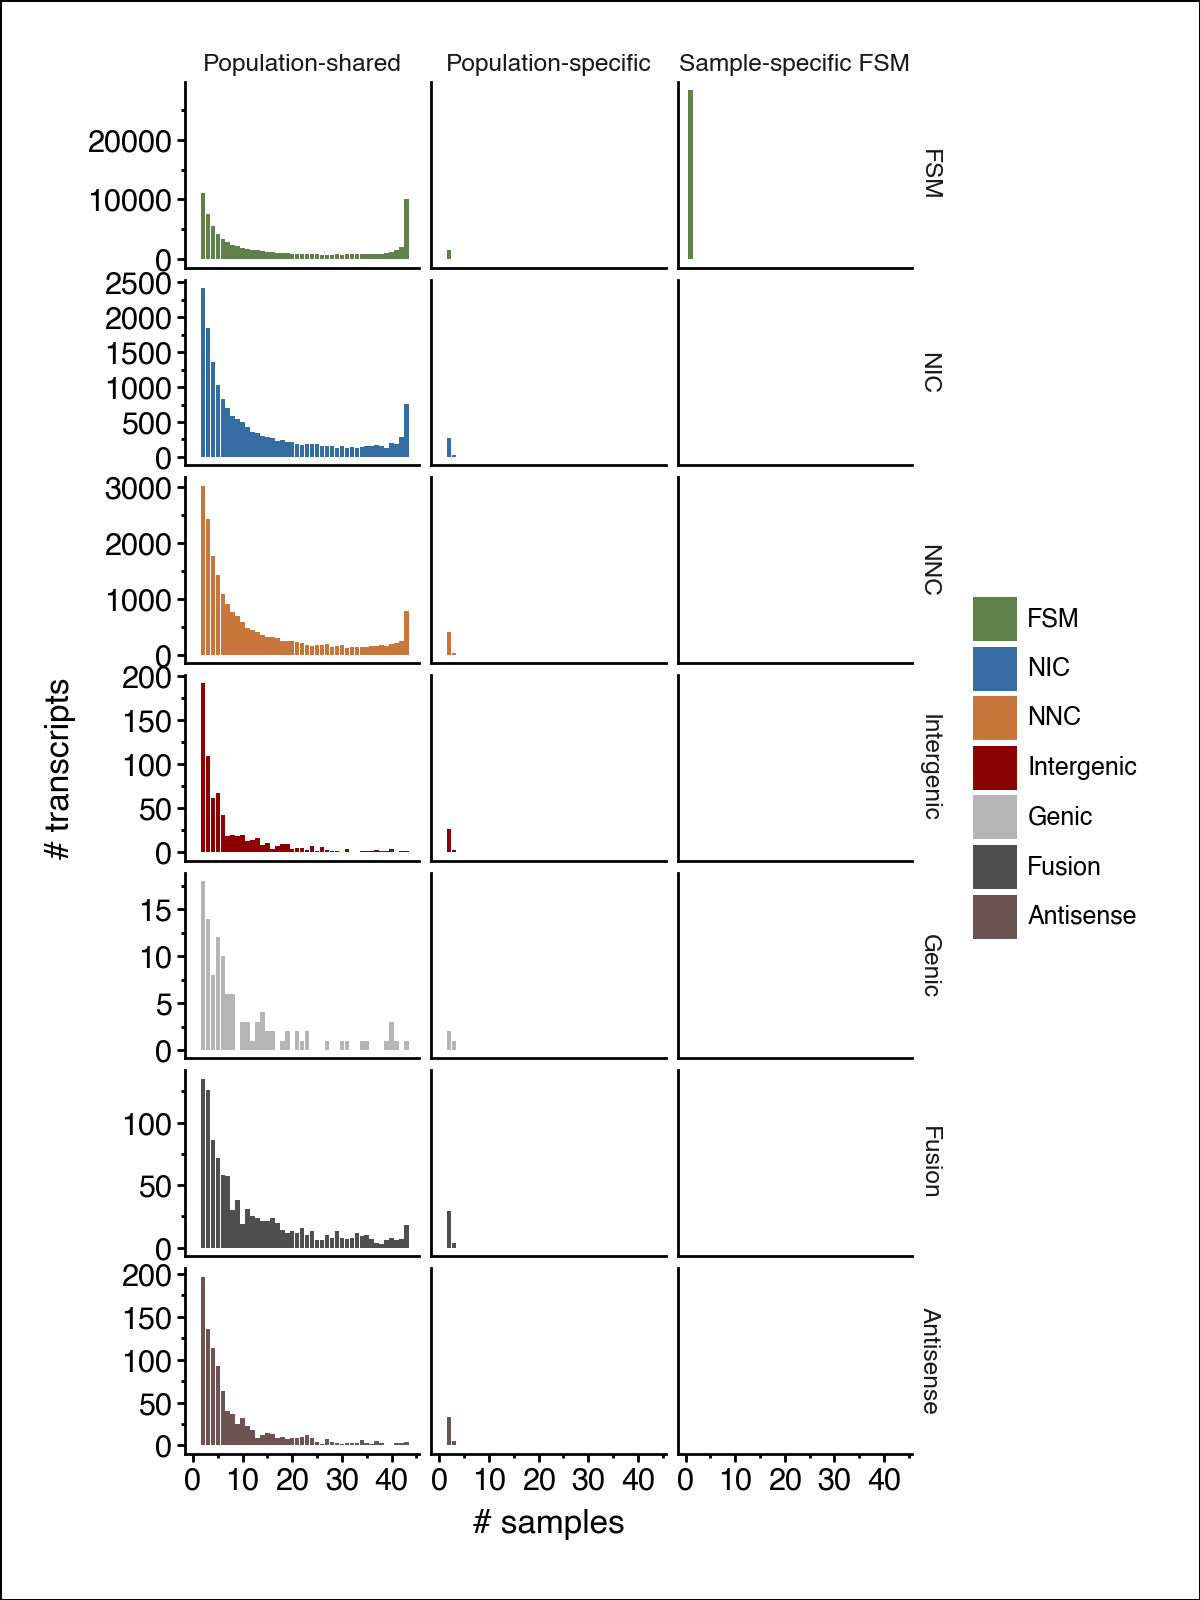

In [58]:
(ggplot(temp, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=8)
        +labs(y='# transcripts',
              x='# samples')
)


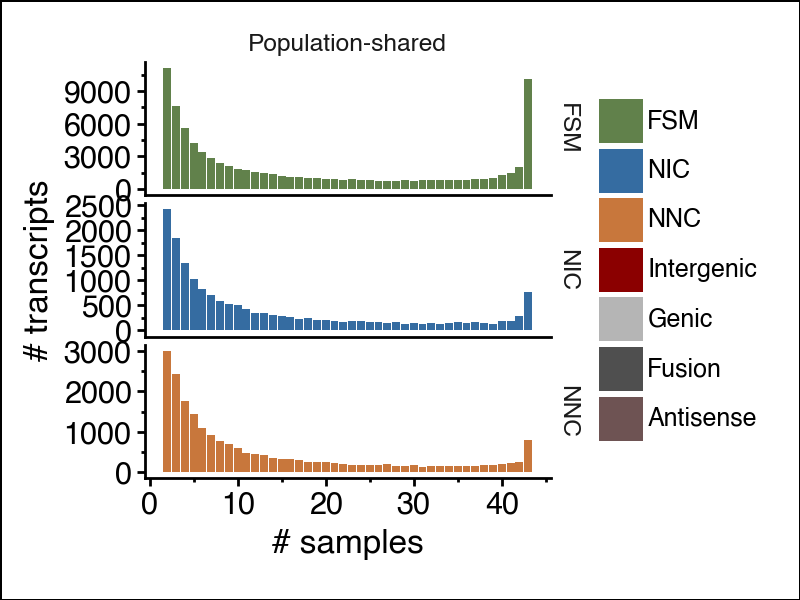

In [59]:
# just population-shared
temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]
temp2 = temp2.loc[temp2.cat=='Population-shared']
(ggplot(temp2, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme()
        +labs(y='# transcripts',
              x='# samples')
)


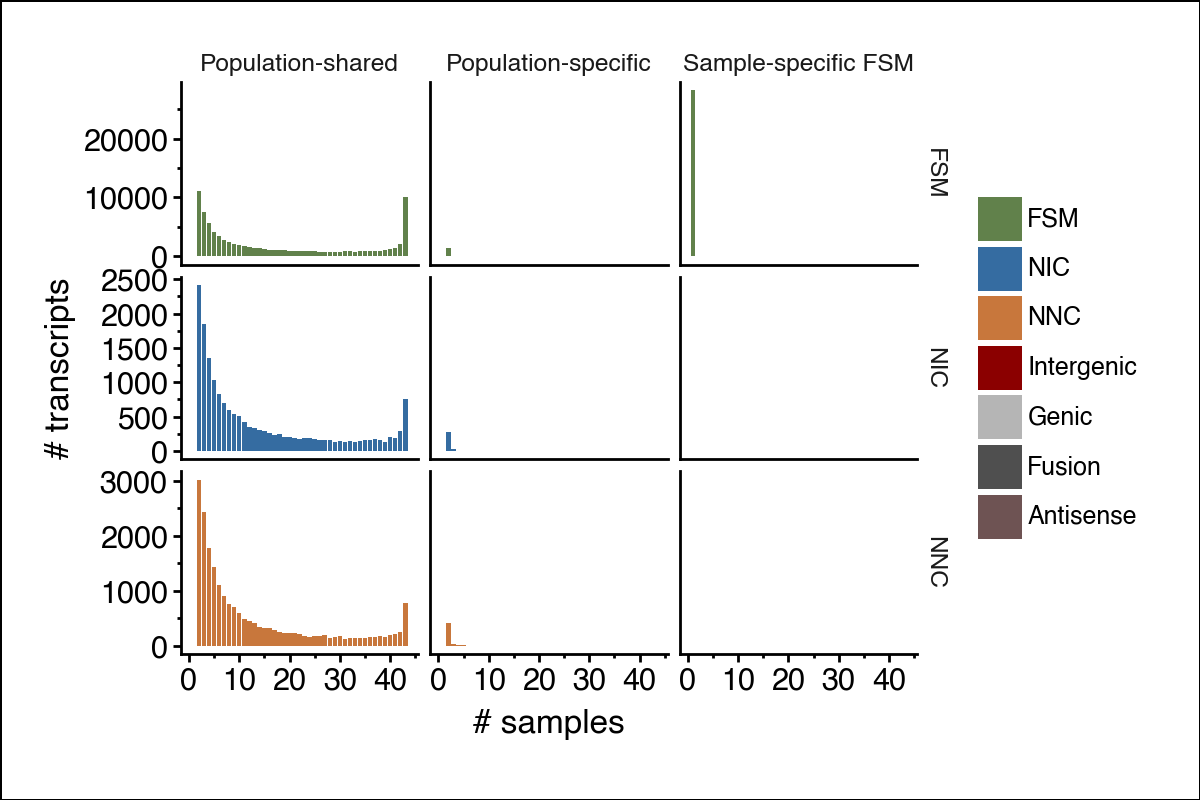

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: n_samples_per_pop_shared_nov_with_legend.pdf


In [62]:
temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]
p = (ggplot(temp2, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=4)
        +labs(y='# transcripts',
              x='# samples')
    

)
p.show()
p.save('n_samples_per_pop_shared_nov_with_legend.pdf', width=6, height=4, dpi=500)



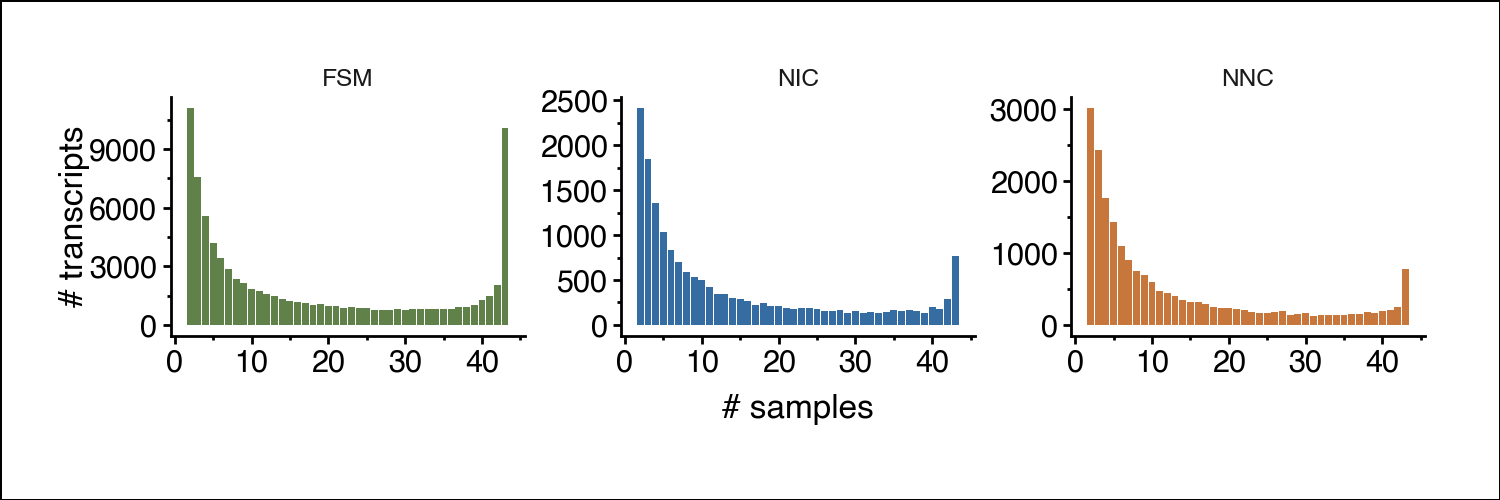

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 2.5 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: n_samples_per_pop_shared_nov.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [76]:
# figure for the paper: all novelty categories, facet and make 1 row of 4 1 row of 3

temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]

temp2['label_y'] = temp2['n_t'] * 1.01
temp2['label_y_2'] = temp2['n_t'] * 1.1

temp2['perc_label'] = temp2['perc'].astype(float).map(lambda x: f"{x:.1f}%")

temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]
temp2 = temp2.loc[temp2.cat=='Population-shared']
p = (ggplot(temp2, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        + geom_text(aes(y='label_y', label='perc_label'), size=7,
                va='bottom')
        +scale_fill_manual(values=c_dict)
         + facet_wrap('~structural_category', nrow=1, scales='free_y')
        + my_theme(h=2.5, w=7.5)
        +labs(y='# transcripts',
              x='# samples')
        + theme(legend_position='none')
    

)
p.show()
p.save('n_samples_per_pop_shared_nov.pdf', width=8, height=2.5, dpi=500)


In [ ]:
# figure for the paper: all novelty categories, facet and make 1 row of 4 1 row of 3

temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]

temp2['label_y'] = temp2['n_t'] * 1.01
temp2['label_y_2'] = temp2['n_t'] * 1.1

temp2['perc_label'] = temp2['perc'].astype(float).map(lambda x: f"{x:.1f}%")

temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]
temp2 = temp2.loc[temp2.cat=='Population-shared']
p = (ggplot(temp2, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        + geom_text(aes(y='label_y', label='perc_label'), size=7,
                va='bottom')
        +scale_fill_manual(values=c_dict)
         + facet_wrap('~structural_category', nrow=1, scales='free_y')
        + my_theme(h=2.5, w=7.5)
        +labs(y='# transcripts',
              x='# samples')
        + theme(legend_position='none')
    

)
p.show()
p.save('n_samples_per_pop_shared_nov.pdf', width=8, height=2.5, dpi=500)


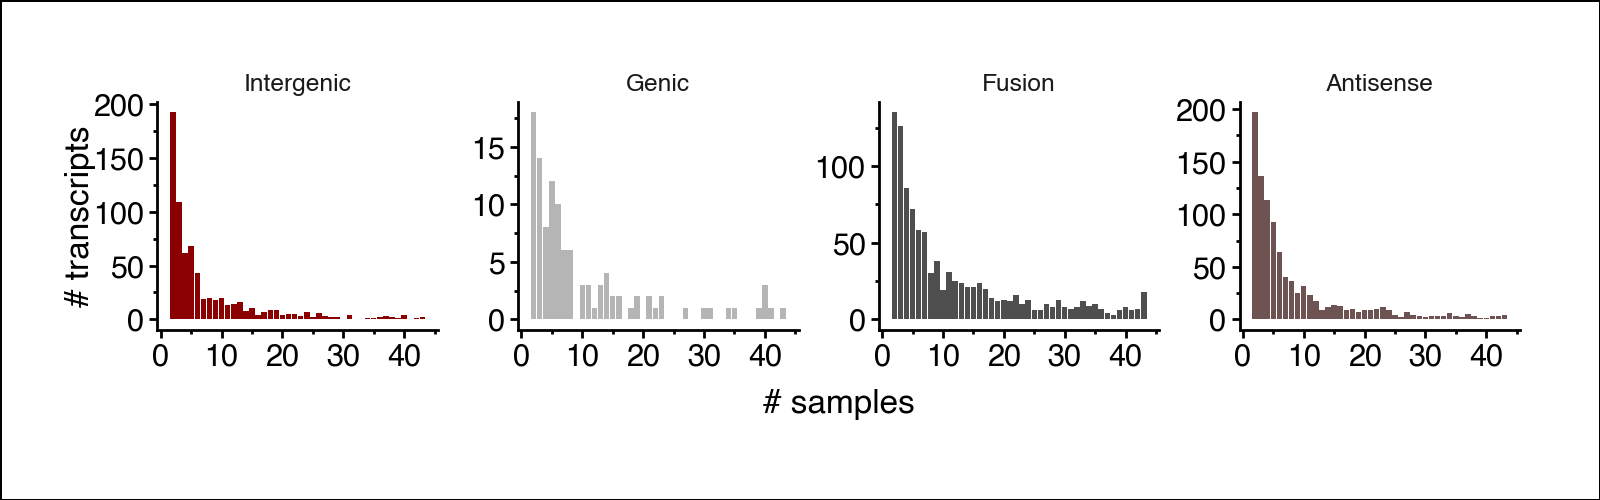

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 2.5 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: n_samples_per_pop_shared_crappy_nov.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [77]:
# figure for the paper: all novelty categories, facet and make 1 row of 4 1 row of 3
temp2 = temp.loc[temp.structural_category.isin(['Intergenic', 'Genic', 'Fusion', 'Antisense'])]
temp2 = temp2.loc[temp2.cat=='Population-shared']
p = (ggplot(temp2, aes(x='sample_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
         + facet_wrap('~structural_category', nrow=1, scales='free_y')
        + my_theme(h=2.5, w=8)
        +labs(y='# transcripts',
              x='# samples')
    + theme(legend_position='none')
    

)
p.show()
p.save('n_samples_per_pop_shared_crappy_nov.pdf', width=8, height=2.5, dpi=500)


## What % of transcripts are expressed in 100%, 50%, 25% of samples?

In [40]:
# limit first to population-shared
temp = temp.loc[temp.cat=='Population-shared']

In [220]:
sample_percs = [10, 25, 50, 75, 100]
n_samples = 43
n_sample_threshes = [int((p/100)*n_samples) for p in sample_percs]
n_sample_threshes

big_df = pd.DataFrame()
for min_samples, min_perc in zip(n_sample_threshes, sample_percs):
    temp['over_thresh'] = temp.sample_sharing>=min_samples
    temp['n_t_tot'] = temp[['structural_category', 'n_t']].groupby('structural_category').transform('sum')
    temp['n_t_over_thresh'] = temp[['structural_category', 'over_thresh', 'n_t']].groupby(['structural_category', 'over_thresh']).transform('sum')
    
    temp2 = temp.loc[temp.over_thresh == True]
    temp2 = temp2[['cat', 'structural_category', 'n_t_tot', 'n_t_over_thresh']].drop_duplicates()
    temp2['perc'] = (temp2['n_t_over_thresh']/temp2['n_t_tot'])*100
    temp2['min_%_samples'] = min_perc
    temp2['min_samples'] = min_samples
    
    big_df = pd.concat([big_df, temp2], axis=0)
big_df['samples_text'] = big_df['min_%_samples'].astype(str)+'% (n='+\
                         big_df['min_samples'].astype(str)+')'

    

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_45080/3307387206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_45080/3307387206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_45080/3307387206.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

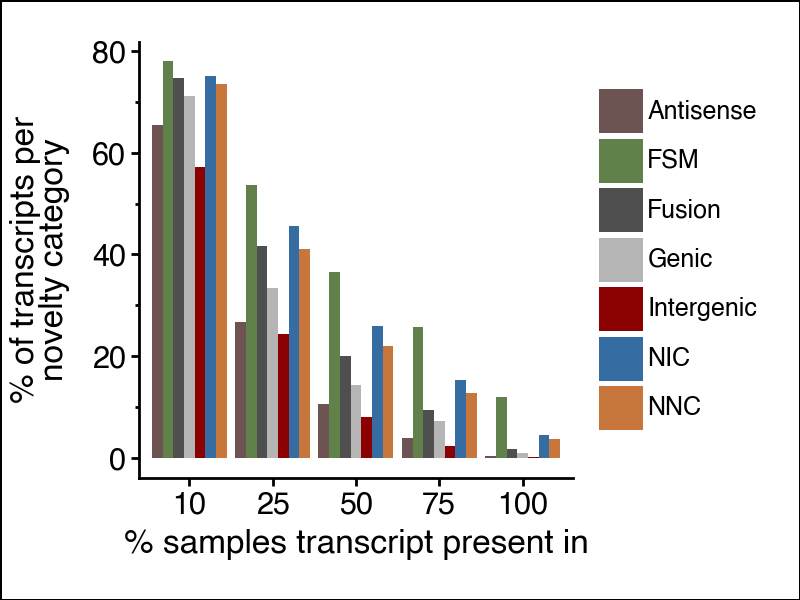

In [221]:
big_df = big_df.sort_values(by='min_%_samples', ascending=True)
ordered_cats = big_df['min_%_samples'].unique().tolist()
big_df['min_%_samples'] = pd.Categorical(big_df['min_%_samples'], categories=ordered_cats, ordered=True)

(ggplot(big_df, aes(x='min_%_samples', y='perc', fill='structural_category'))
 +geom_bar(stat='identity', position='dodge')
 +scale_fill_manual(values=c_dict)
 +my_theme()
 +labs(x='% samples transcript present in',
       y='% of transcripts per\nnovelty category')
)

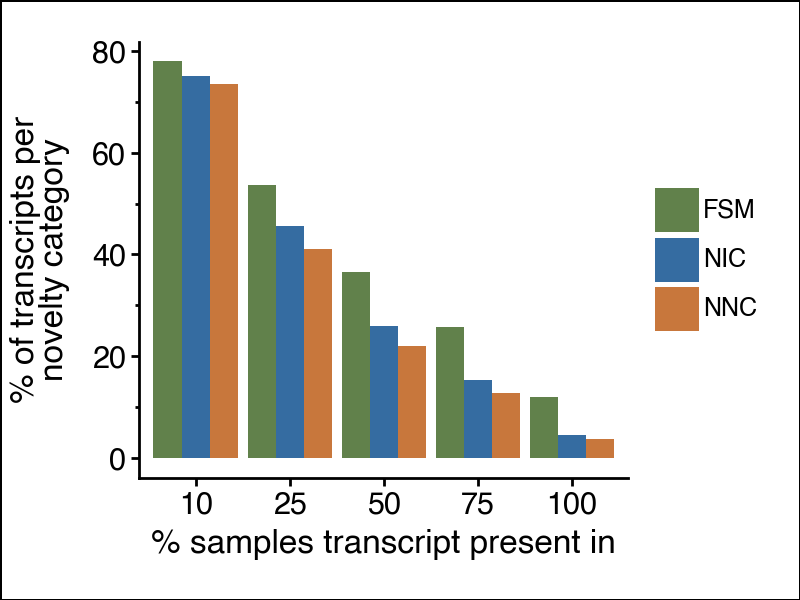

In [222]:
# one w/o weird novelty cats
temp = big_df.loc[big_df.structural_category.isin(['FSM', 'NIC', 'NNC'])]

(ggplot(temp, aes(x='min_%_samples', y='perc', fill='structural_category'))
 +geom_bar(stat='identity', position='dodge')
 +scale_fill_manual(values=c_dict)
 +my_theme()
 +labs(x='% samples transcript present in',
       y='% of transcripts per\nnovelty category')
)

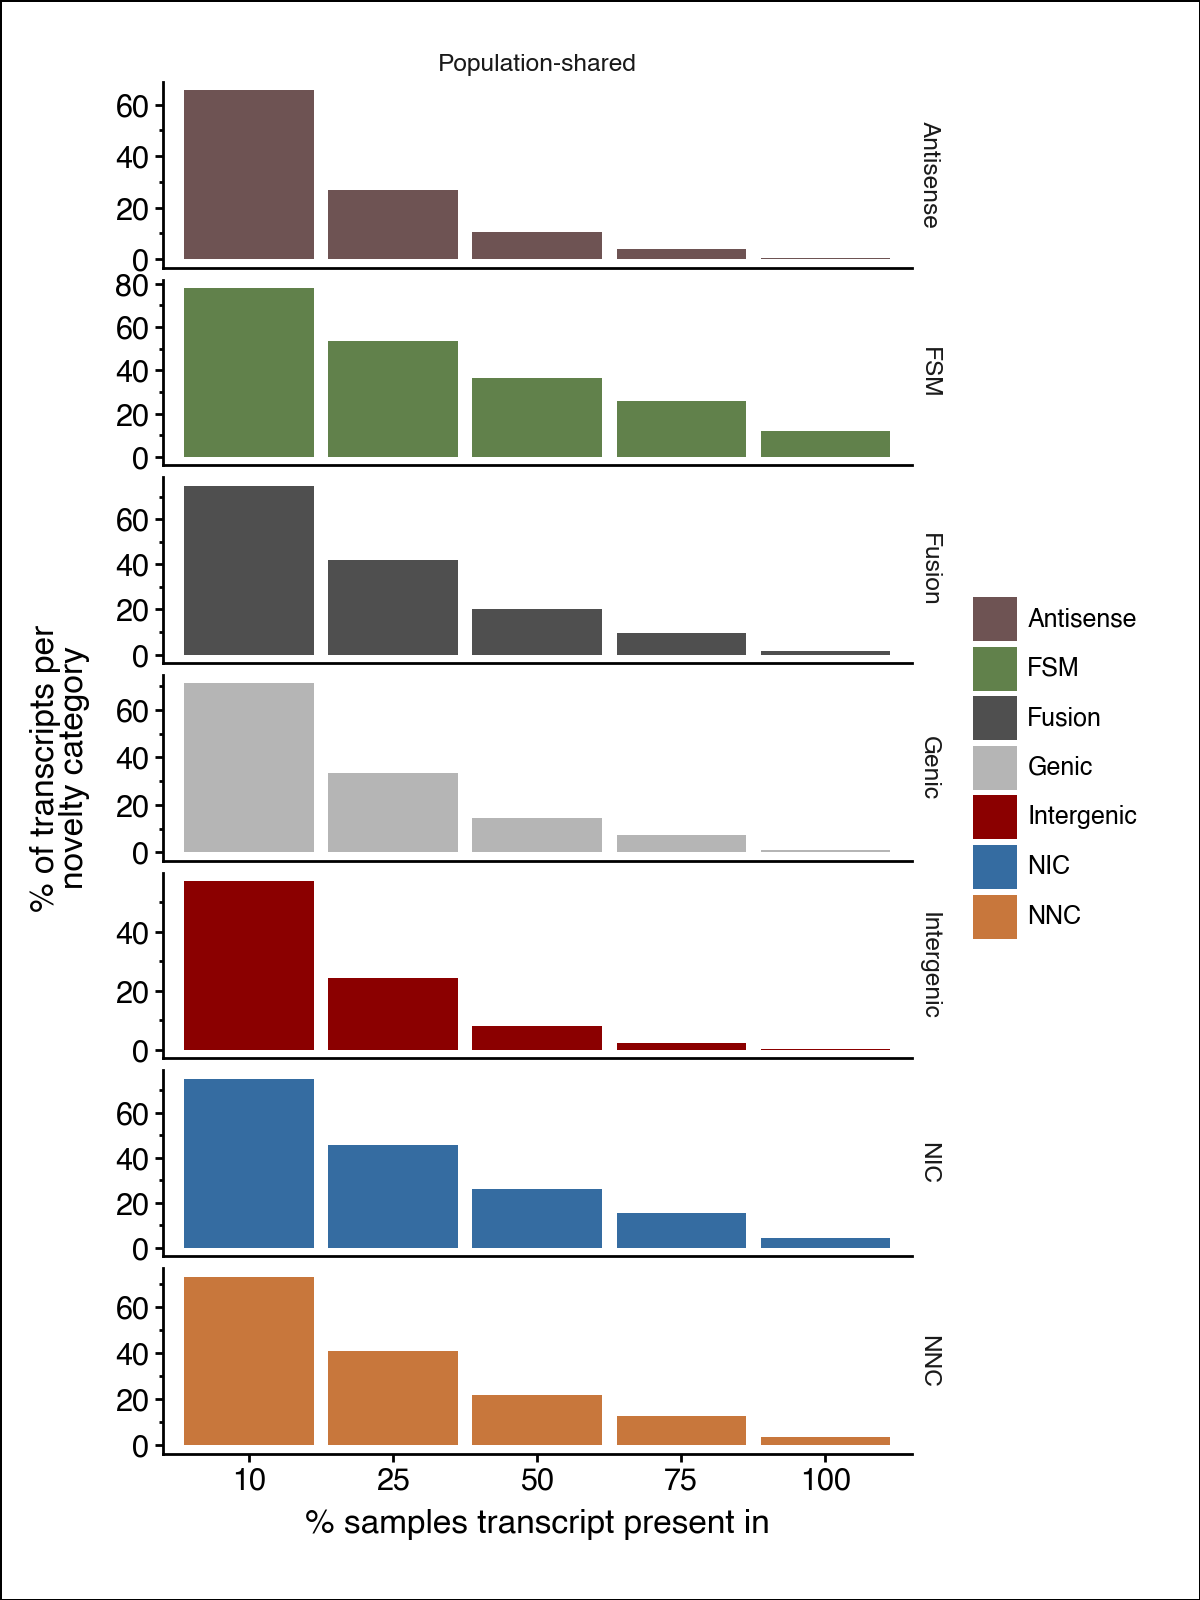

In [223]:
# facet by the pop-spec definitions
(ggplot(big_df, aes(x='min_%_samples', y='perc', fill='structural_category'))
 +geom_bar(stat='identity')
 +scale_fill_manual(values=c_dict)
 +facet_grid('structural_category ~ cat',
                    scales='free_y')
 +my_theme(w=6, h=8)
 +labs(x='% samples transcript present in',
       y='% of transcripts per\nnovelty category')
)


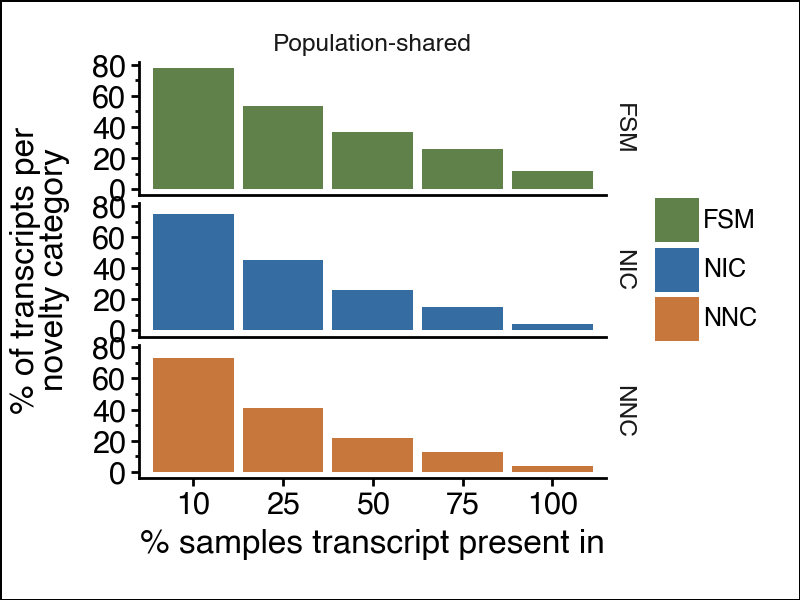

In [224]:
# facet by the pop-spec definitions
temp = big_df.loc[big_df.structural_category.isin(['FSM', 'NIC', 'NNC'])]
(ggplot(temp, aes(x='min_%_samples', y='perc', fill='structural_category'))
 +geom_bar(stat='identity')
 +scale_fill_manual(values=c_dict)
 +facet_grid('structural_category ~ cat',
             scales='fixed')
 +my_theme()
 +labs(x='% samples transcript present in',
       y='% of transcripts per\nnovelty category')
)


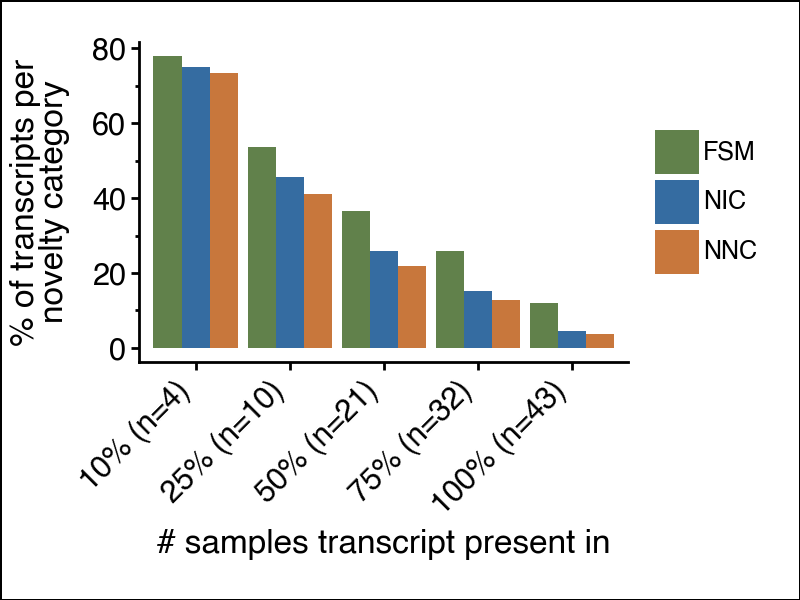

In [225]:
# one w/o weird novelty cats
# also just plot # samples
# Sort by numeric column
big_df = big_df.sort_values(by='min_%_samples')
ordered_labels = big_df['samples_text'].unique().tolist()
big_df['samples_text'] = pd.Categorical(big_df['samples_text'], categories=ordered_labels, ordered=True)

temp = big_df.loc[big_df.structural_category.isin(['FSM', 'NIC', 'NNC'])]

(ggplot(temp, aes(x='samples_text', y='perc', fill='structural_category'))
 +geom_bar(stat='identity', position='dodge')
 +scale_fill_manual(values=c_dict)
 +my_theme()
 +labs(x='# samples transcript present in',
       y='% of transcripts per\nnovelty category')
 +theme(axis_text_x=element_text(rotation=45, hjust=1))
)

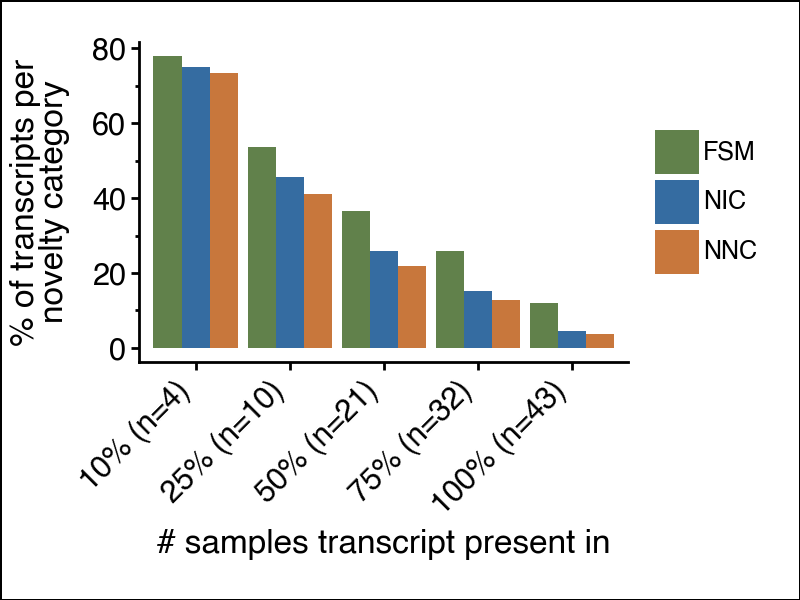

In [226]:
# one w/o weird novelty cats
# also just plot # samples
# Sort by numeric column
big_df = big_df.sort_values(by='min_%_samples')
ordered_labels = big_df['samples_text'].unique().tolist()
big_df['samples_text'] = pd.Categorical(big_df['samples_text'], categories=ordered_labels, ordered=True)

(ggplot(temp, aes(x='samples_text', y='perc', fill='structural_category'))
 +geom_bar(stat='identity', position='dodge')
 +scale_fill_manual(values=c_dict)
 +my_theme()
 +labs(x='# samples transcript present in',
       y='% of transcripts per\nnovelty category')
 +theme(axis_text_x=element_text(rotation=45, hjust=1))
)

## Of the population-shared transcripts, what other populations do they occur in ? 

In [196]:
df = mt_df.loc[mt_df.cat == 'Population-shared']

pops = get_population_colors()[1]
df = df[['isoform']+pops]
df.set_index('isoform', inplace=True)

# make sure no things only in one sample are in here 
df['thing'] = df.sum(axis=1)
assert len(df.loc[df.thing==1].index) == 0
df = df.drop('thing', axis=1)

In [197]:
# make sure no things only in one population are in here,
# because they should belong to the population-specific transcripts
df = df[pops] > 0
df['thing'] = df.sum(axis=1)
assert len(df.loc[df.thing==1].index) == 0
df = df.drop('thing', axis=1)

In [198]:
df = df.reset_index()
df = df.set_index(pops)

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

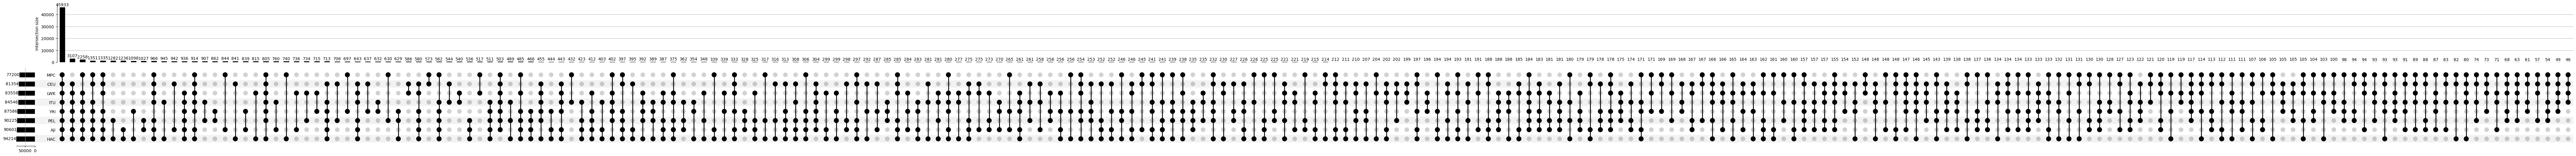

In [199]:
upset = upsetplot.UpSet(df, sort_by='cardinality', show_counts=True)
upset.plot()
plt.show()

## Look at the distribution of different # of populations
ie how many transcripts that are shared are shared between 2 pops? 3 pops? etc.


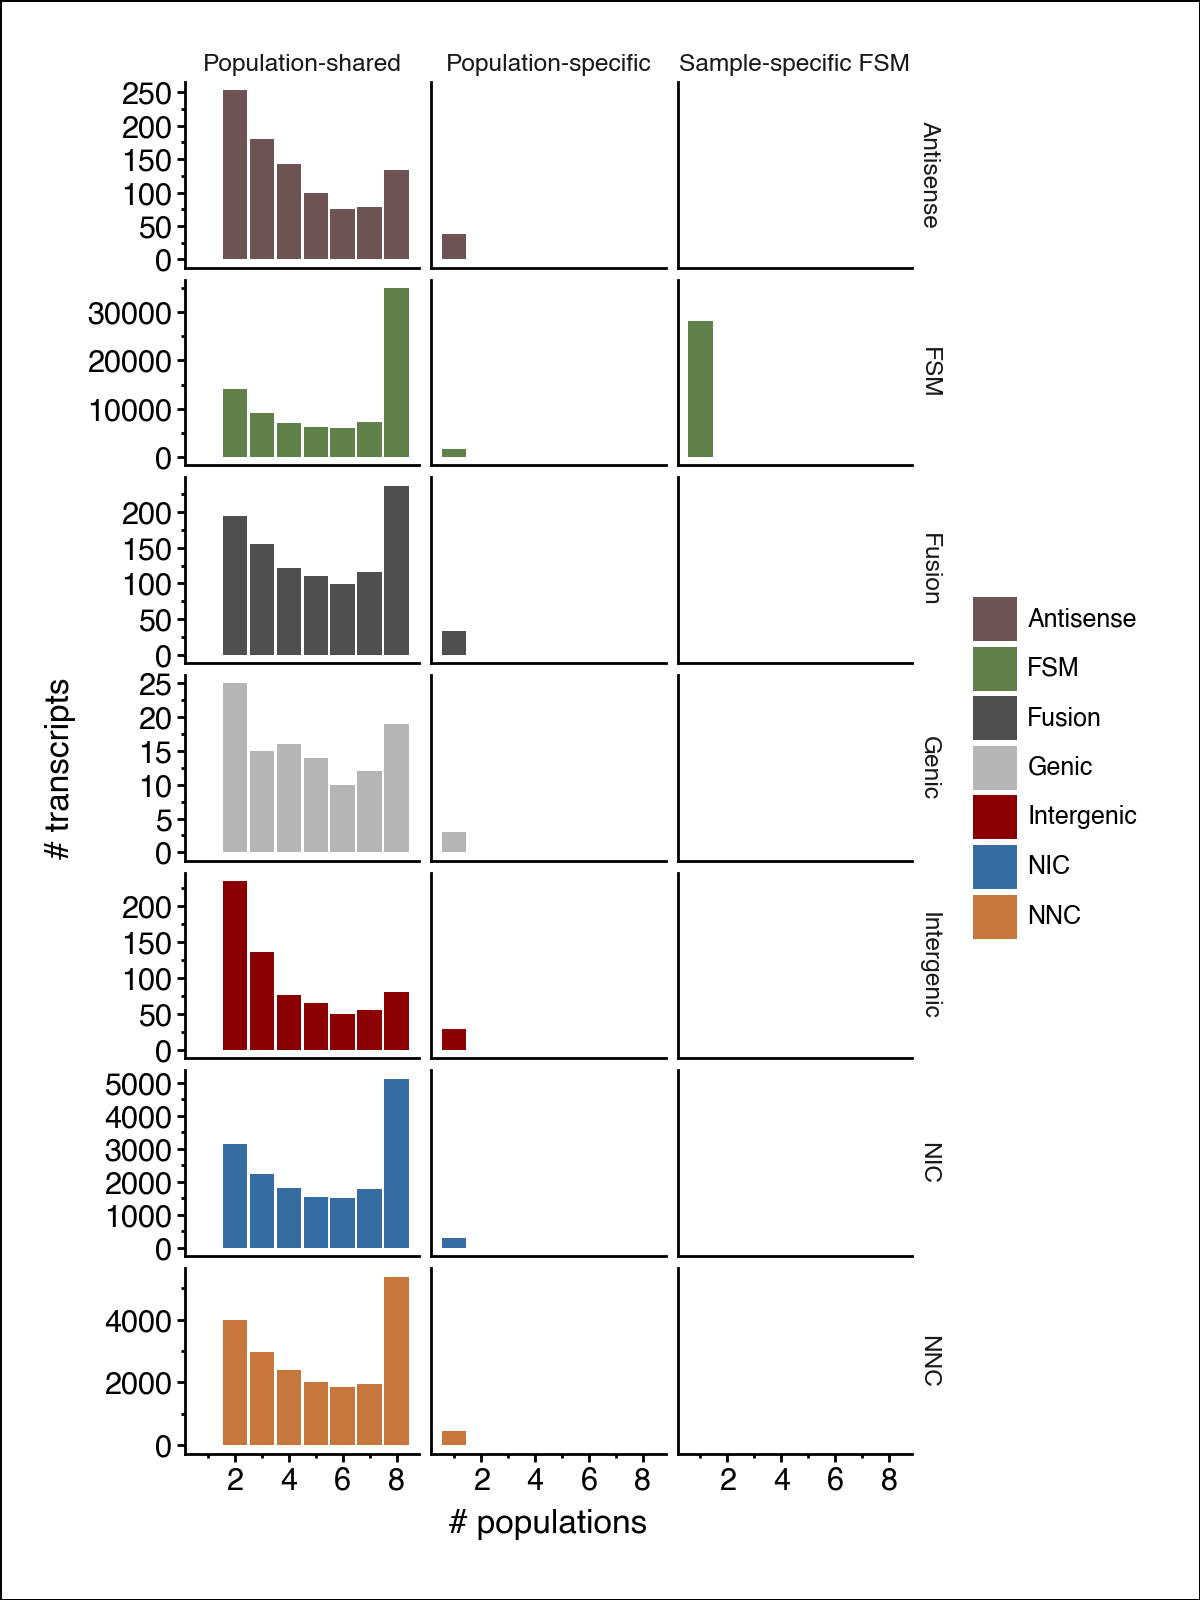

In [105]:
# facet by structural category
df = mt_df[['isoform',
         'cat',
         'structural_category',
         'population_sharing']].groupby(['structural_category', 'cat', 'population_sharing']).nunique().reset_index().rename({'isoform':'n_t'}, axis=1)

(ggplot(df, aes(x='population_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=8)
        +labs(y='# transcripts',
              x='# populations')
)


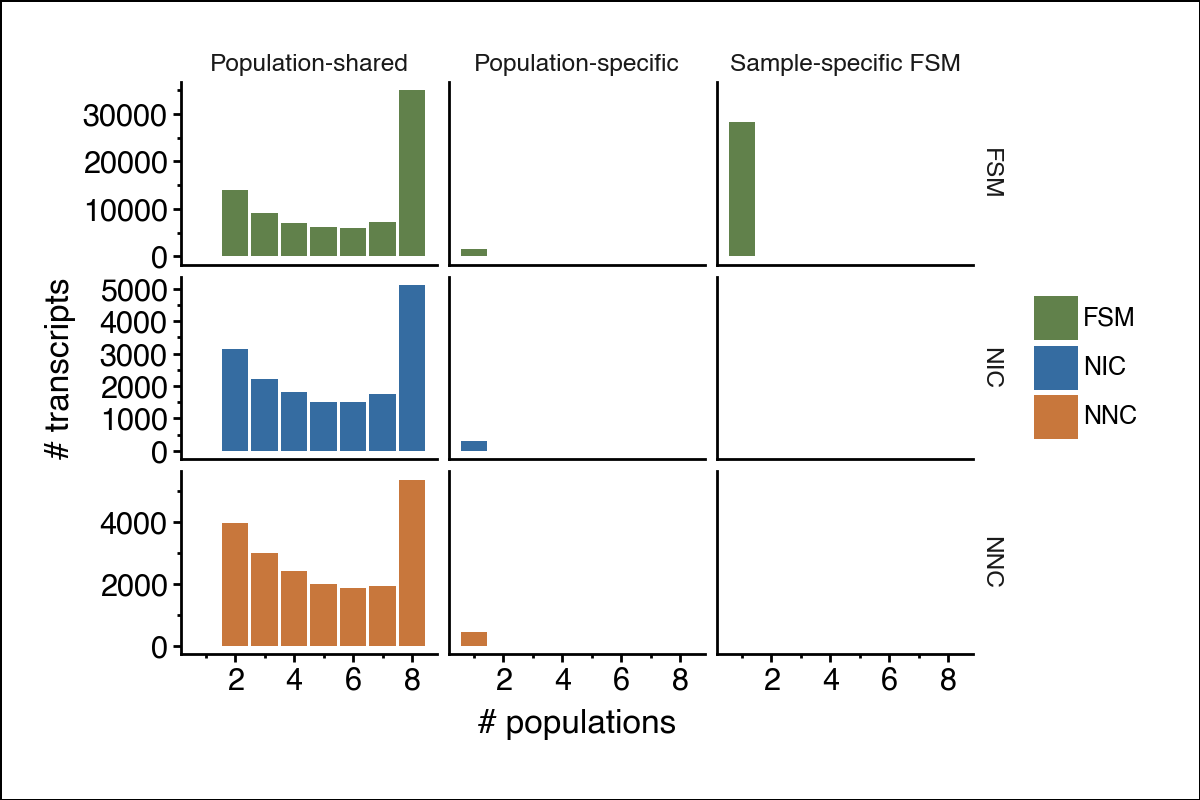

In [106]:
# facet by structural category
# only categories I care about

df = mt_df[['isoform',
         'cat',
         'structural_category',
         'population_sharing']].groupby(['structural_category', 'cat', 'population_sharing']).nunique().reset_index().rename({'isoform':'n_t'}, axis=1)
temp = df.loc[df.structural_category.isin(['FSM', 'NIC', 'NNC'])]

(ggplot(temp, aes(x='population_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
        +facet_grid('structural_category ~ cat',
                    scales='free_y')
        +my_theme(w=6, h=4)
        +labs(y='# transcripts',
              x='# populations')
)


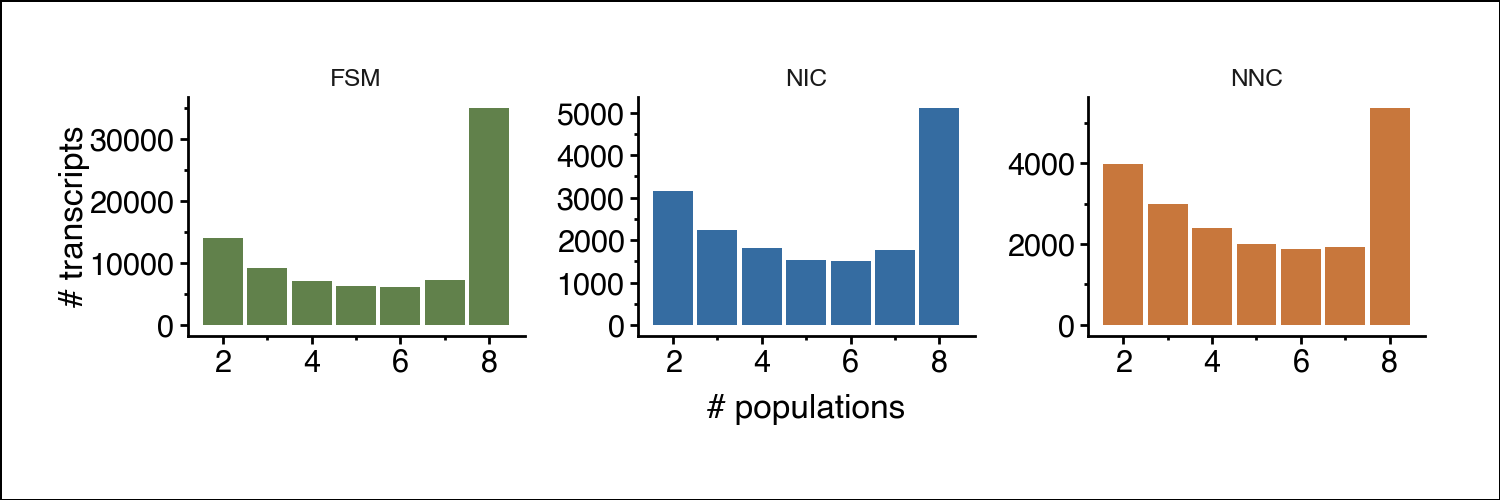

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 2.5 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: n_pops_per_pop_shared_nov.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [107]:
df['structural_category'] = pd.Categorical(df['structural_category'], categories=order, ordered=True)
df = df.sort_values('structural_category')

# figure for the paper: all novelty categories, facet and make 1 row of 4 1 row of 3
temp2 = df.loc[df.structural_category.isin(['FSM', 'NIC', 'NNC'])]
temp2 = temp2.loc[temp2.cat=='Population-shared']

p = (ggplot(temp2, aes(x='population_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
         + facet_wrap('~structural_category', nrow=1, scales='free_y')
        + my_theme(h=2.5, w=7.5)
        +labs(y='# transcripts',
              x='# populations')
        + theme(legend_position='none')
    

)
p.show()
p.save('n_pops_per_pop_shared_nov.pdf', width=8, height=2.5, dpi=500)


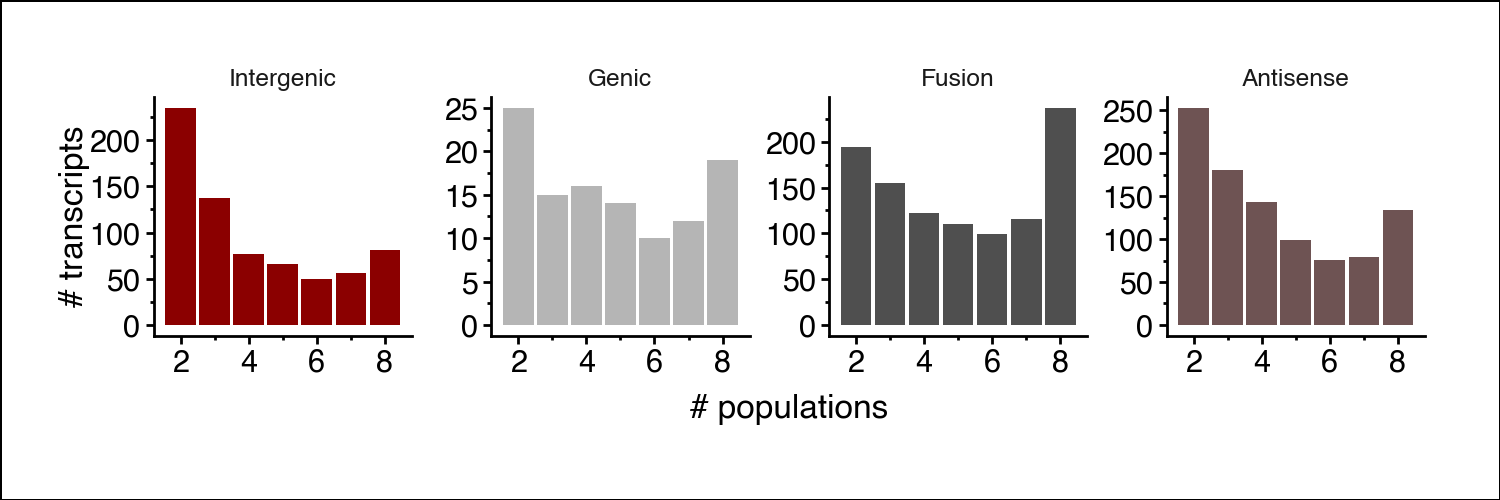

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 2.5 in image.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: n_pops_per_pop_shared_bad_novs_nov.pdf
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [108]:
# figure for the paper: all novelty categories, facet and make 1 row of 4 1 row of 3
temp2 = df.loc[df.structural_category.isin(['Intergenic', 'Genic', 'Fusion', 'Antisense'])]
temp2 = temp2.loc[temp2.cat=='Population-shared']

p = (ggplot(temp2, aes(x='population_sharing', y='n_t', fill='structural_category'))
        +geom_bar(stat='identity')
        +scale_fill_manual(values=c_dict)
         + facet_wrap('~structural_category', nrow=1, scales='free_y')
        + my_theme(h=2.5, w=7.5)
        +labs(y='# transcripts',
              x='# populations')
        + theme(legend_position='none')
    

)
p.show()
p.save('n_pops_per_pop_shared_bad_novs_nov.pdf', width=8, height=2.5, dpi=500)


In [149]:
# get the same plots as above but with the percentages
temp = df.loc[df.cat=='Population-shared']
temp['n_total_t_nov'] = temp[['n_t', 'structural_category']].groupby('structural_category').transform('sum')
temp['perc'] = (temp['n_t']/temp['n_total_t_nov'])*100
# temp.loc[temp.population_sharing==8]
# temp['perc'] = temp['perc'].astype(float)
# temp['perc_label'] = temp['perc'].map(lambda x: f"{x:.1f}%").astype(str)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/4221731344.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/4221731344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/4221731344.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3960379428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3960379428.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3960379428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

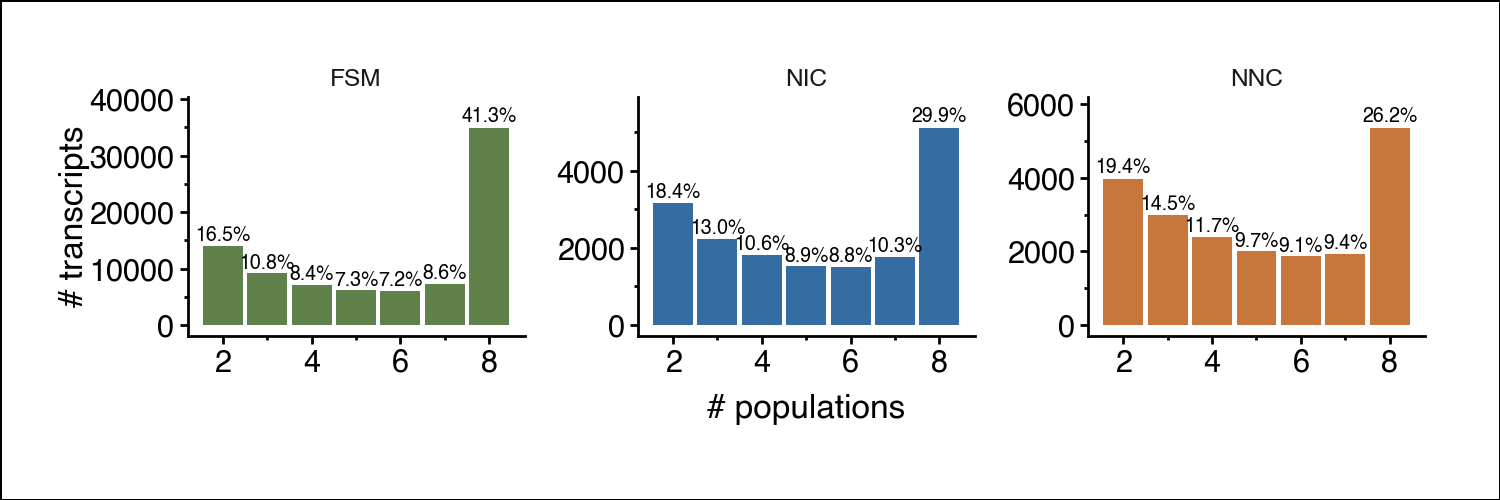

In [151]:
temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]

temp2['label_y'] = temp2['n_t'] * 1.01
temp2['label_y_2'] = temp2['n_t'] * 1.1

temp2['perc_label'] = temp2['perc'].astype(float).map(lambda x: f"{x:.1f}%")

p = (
    ggplot(temp2, aes(x='population_sharing', y='n_t', fill='structural_category'))
    + geom_blank(aes(y='label_y_2'))
    + geom_bar(stat='identity')
    + geom_text(aes(y='label_y', label='perc_label'), size=7,
                va='bottom')
    + scale_fill_manual(values=c_dict)
    + facet_wrap('~structural_category', nrow=1, scales='free_y')
    + my_theme(h=2.5, w=7.5)
    + labs(y='# transcripts', x='# populations')
    + theme(legend_position='none')
)

p.save('n_pops_per_pop_shared_nov.pdf', width=8, height=2.5, dpi=500)
p.show()

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/345268868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/345268868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/345268868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

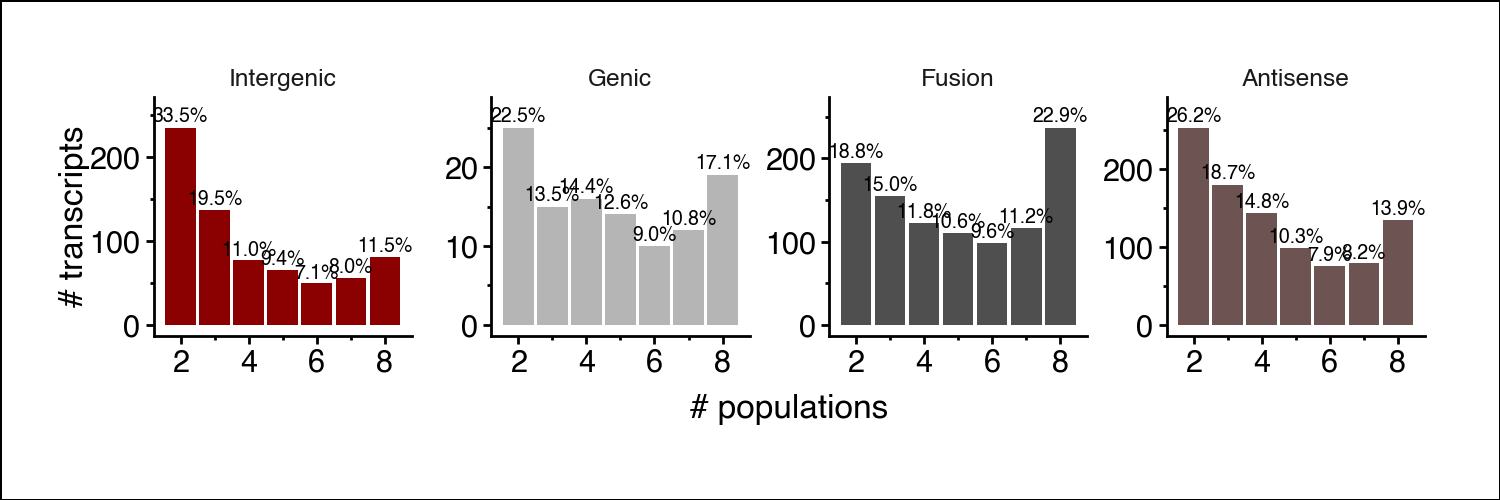

In [152]:
temp2 = temp.loc[temp.structural_category.isin(['Intergenic', 'Genic', 'Fusion', 'Antisense'])]
temp2['label_y'] = temp2['n_t'] * 1.01
temp2['label_y_2'] = temp2['n_t'] * 1.1

temp2['perc_label'] = temp2['perc'].astype(float).map(lambda x: f"{x:.1f}%")

p = (
    ggplot(temp2, aes(x='population_sharing', y='n_t', fill='structural_category'))
    + geom_blank(aes(y='label_y_2'))
    + geom_bar(stat='identity')
    + geom_text(aes(y='label_y', label='perc_label'), size=7,
                va='bottom')
    + scale_fill_manual(values=c_dict)
    + facet_wrap('~structural_category', nrow=1, scales='free_y')
    + my_theme(h=2.5, w=7.5)
    + labs(y='# transcripts', x='# populations')
    + theme(legend_position='none')
)

p.save('n_pops_per_pop_shared_bad_novs_nov.pdf', width=8, height=2.5, dpi=500)
p.show()

In [122]:
temp.loc[temp.perc.isnull()]

,structural_category,cat,population_sharing,n_t,n_total_t_nov,perc,perc_label


In [123]:
def is_not_float(x):
    try:
        float(x)
        return False
    except:
        return True

temp2[temp2['perc'].apply(is_not_float)]

,structural_category,cat,population_sharing,n_t,n_total_t_nov,perc,perc_label


In [101]:
# what % of transcripts in each are present in all populations?
df = mt_df.loc[mt_df.cat=='Population-shared']
df['n_total_t'] = df[['isoform', 'structural_category']].groupby('structural_category').transform('nunique')
df['in_all'] = df['population_sharing'] == 8
df['n_t_in_all'] = df[['isoform', 'in_all', 'structural_category']].groupby(['in_all', 'structural_category']).transform('nunique')
df = df[['in_all', 'n_t_in_all', 'structural_category', 'n_total_t']].drop_duplicates()

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3805414361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3805414361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3805414361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [102]:
df['perc'] = (df['n_t_in_all']/df['n_total_t'])*100
df.loc[df.in_all==True]

,in_all,n_t_in_all,structural_category,n_total_t,perc
44,True,5366,NNC,20516,26.155196
55,True,34978,FSM,84793,41.251047
435,True,237,Fusion,1033,22.942885
1939,True,5118,NIC,17120,29.894860
2329,True,134,Antisense,964,13.900415
2446,True,81,Intergenic,702,11.538462
13644,True,19,Genic,111,17.117117


In [69]:
# what % of transcripts in each are present in all populations?
df = mt_df.loc[mt_df.cat=='Population-shared']
df['n_total_t'] = df[['isoform', 'structural_category']].groupby('structural_category').transform('nunique')
df['in_all'] = df['population_sharing'] == 8
df['n_t_in_all'] = df[['isoform', 'in_all', 'structural_category']].groupby(['in_all', 'structural_category']).transform('nunique')
df = df[['in_all', 'n_t_in_all', 'structural_category', 'n_total_t']].drop_duplicates()

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3805414361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3805414361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_51006/3805414361.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [70]:
df

,in_all,n_t_in_all,structural_category,n_total_t
2,False,49815,FSM,84793
36,False,15150,NNC,20516
44,True,5366,NNC,20516
55,True,34978,FSM,84793
112,False,796,Fusion,1033
336,False,12002,NIC,17120
435,True,237,Fusion,1033
1877,False,830,Antisense,964
1939,True,5118,NIC,17120
2329,True,134,Antisense,964
